# Bitcoin transaction graph


In [1]:
import os

import json
from pprint import pprint

import pandas as pd
import numpy as np

import networkx as nx

from risk_analytics import utils as ut
#from node2vec import node2vec as n2v

from importlib import reload

#reload(n2v)
reload(ut)

<module 'risk_analytics.utils' from '/Users/pavel/py_pavel/QRM_workshops/risk_analytics/risk_analytics/utils.py'>

In [113]:
plt.style.use('ggplot')
%matplotlib inline

pd.set_option("display.max_columns",100)

fig_dir = "../slides/figures"
if not os.path.exists(fig_dir):
    print("Creating figure directory")
    os.makedirs(fig_dir)

## Query by block height

In [114]:
query_blockchain = False
save_me = False
max_height = 52700
if query_blockchain:
   
    block_list = ut.get_blockchain(max_height, verbose = True)
    if save_me: # Write to file
        with open('../blockchain_list_flat.json', 'w') as outfile:
        json.dump(block_list_flat, outfile)
else: # Load from disk
    with open('../blockchain_list_flat.json') as infile:    
        block_list = json.load(infile)

## Problems

1. `*` At which height is the first non-mining bitcoin transaction?
2. Assume that all mining fees come from the a single source, i.e a single node. How many connected components does the bitcoin transaction graph have?

In [115]:
col_dict = [('addr', 'addr_to'),
            ('prev_addr', 'addr_from'),
            ('height', 'height'),
            ('script_x', 'script_out'),
            ('script_y', 'script_in'),
            ('spent', 'spent_flag'),
            ('value', 'value')]

block_df = ut.blocks2df(block_list, col_dict)
block_df = block_df.rename(columns={'value': 'weight'})
block_df['addr_from'] = block_df['addr_from'].fillna('mining')
pd.set_option("display.max_colwidth",35)
print(block_df.shape)
block_df.head()

(52724, 7)


,addr_to,addr_from,height,script_out,script_in,spent_flag,weight
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,mining,0,4104678afdb0fe5548271967f1a6713...,04ffff001d0104455468652054696d6...,False,5000000000
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,mining,1,410496b538e853519c726a2c91e61ec...,04ffff001d0104,False,5000000000
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,mining,2,41047211a824f55b505228e4c3d5194...,04ffff001d010b,False,5000000000
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,mining,3,410494b9d3e76c5b1629ecf97fff95d...,04ffff001d010e,False,5000000000
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,mining,4,4104184f32b212815c6e522e6668632...,04ffff001d011a,False,5000000000


In [116]:
# Split into peer2peer and mining transactions
pd.set_option("display.max_colwidth",32)
p2p = block_df.loc[pd.notnull(block_df['addr_from']), :]
mining = block_df.loc[pd.notnull(block_df['script_in']), :]
p2p.head(10)

,addr_to,addr_from,height,script_out,script_in,spent_flag,weight
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7...,mining,0,4104678afdb0fe5548271967f1a6...,04ffff001d010445546865205469...,False,5000000000
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMB...,mining,1,410496b538e853519c726a2c91e6...,04ffff001d0104,False,5000000000
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y5...,mining,2,41047211a824f55b505228e4c3d5...,04ffff001d010b,False,5000000000
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg...,mining,3,410494b9d3e76c5b1629ecf97fff...,04ffff001d010e,False,5000000000
4,15ubicBBWFnvoZLT7GiU2qxjRaKJ...,mining,4,4104184f32b212815c6e522e6668...,04ffff001d011a,False,5000000000
5,1JfbZRwdDHKZmuiZgYArJZhcuuzu...,mining,5,410456579536d150fbce94ee62b4...,04ffff001d0120,False,5000000000
6,1GkQmKAmHtNfnD3LHhTkewJxKHVS...,mining,6,410408ce279174b34c077c7b2043...,04ffff001d0123,False,5000000000
7,16LoW7y83wtawMg5XmT4M3Q7Edjj...,mining,7,4104a59e64c774923d003fae7491...,04ffff001d012b,False,5000000000
8,1J6PYEzr4CUoGbnXrELyHszoTSz3...,mining,8,4104cc8d85f5e7933cb18f13b97d...,04ffff001d012c,False,5000000000
9,12cbQLTFMXRnSzktFkuoG3eHoMeF...,mining,9,410411db93e1dcdb8a016b49840f...,04ffff001d0134,True,5000000000


## Plot the transaction graph

/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed

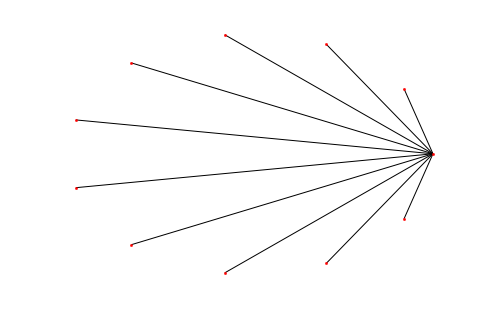

In [117]:
btc_graph = nx.from_pandas_dataframe(block_df.iloc[:10], 'addr_from', 'addr_to', 
                                         edge_attr = ['height', 'weight','spent_flag'],
                                         create_using=nx.Graph())

btc_graph.edges()
#nx.draw_networkx(btc_graph, with_labels=False, node_size = 5)
nx.draw_circular(btc_graph, with_labels=False, node_size = 5)

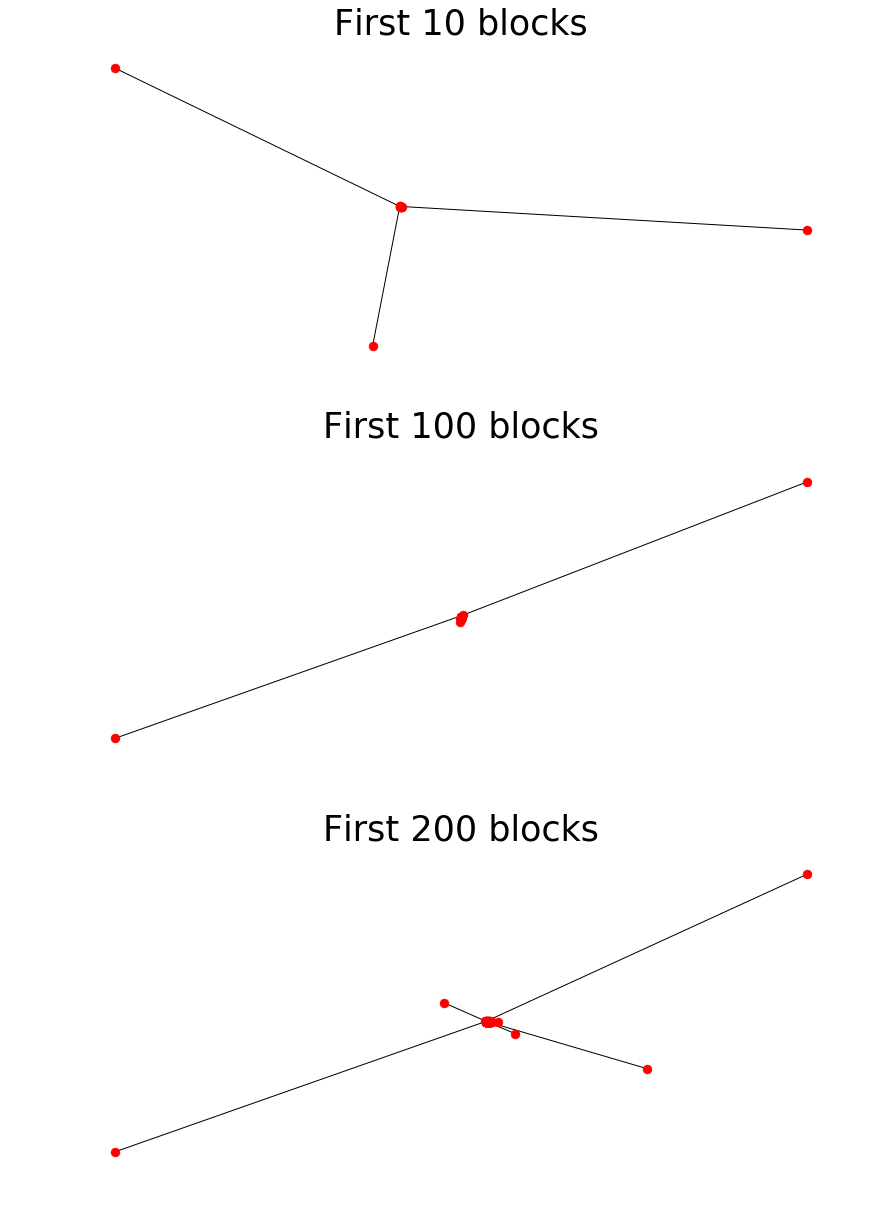

In [118]:
n_blocks = [10, 100, 200]
fig, ax_arr = plt.subplots(len(n_blocks),figsize=(15, len(n_blocks)*7))
for i in range(len(n_blocks)):
    btc_graph = nx.from_pandas_dataframe(block_df.iloc[:n_blocks[i]], 'addr_from', 'addr_to', 
                                         edge_attr = ['height', 'weight','spent_flag'],
                                         create_using=nx.Graph())
    nx.draw_networkx(btc_graph, with_labels=False, node_size = 80, ax=ax_arr[i])
    #nx.draw_circular(btc_graph, with_labels=False, node_size = 80, ax=ax_arr[i])
    #nx.draw_spectral(btc_graph, with_labels=False, node_size = 80, ax=ax_arr[i])

    title = 'First {0} blocks'.format(n_blocks[i])
    #ax_arr[i].set(title=title)
    ax_arr[i].set_title(title, fontsize=35)
    ax_arr[i].set_axis_off()

if save_me:
    fig_file = "first_" + '_'.join([str(n) for n in n_blocks]) + "blocks.png"
    plt.savefig(os.path.join(fig_dir, fig_file), format='png')

## Look at graph characteristics over time / height

/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


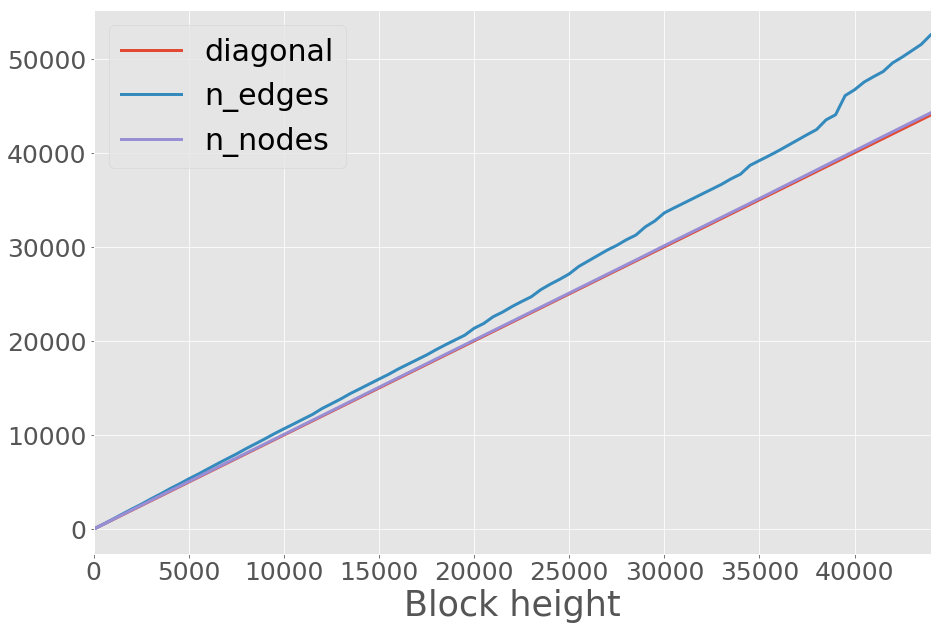

In [124]:
n_nodes = []
n_edges = []

heights = range(0, max(block_df.height), 500)
for height in heights:
    block_h = block_df.loc[block_df['height'] <= height, :]
    edge_df = block_h[['addr_from', 'addr_to']]
    edge_df['edge_data'] = block_h[['height', 'weight']].to_dict(orient='records')
    edge_list = edge_df.values.tolist()
    G = nx.MultiDiGraph(edge_list)
    #nx.draw_networkx(G, with_labels=False, node_size = 80)
    n_nodes.append(G.number_of_nodes())
    n_edges.append(G.number_of_edges())
    #print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))

node_edge_df = pd.DataFrame({'n_nodes': n_nodes,
                             'n_edges': n_edges,
                            'diagonal': heights}, index=heights)
plt.figure();
ax = node_edge_df.plot(figsize=(15, 10), linewidth=3.0);
ax.set_xlabel("Block height", fontsize=35)
plt.legend(loc=2, prop={'size': 30})
plt.tick_params(axis='both', which='major', labelsize=25)

if save_me:
    plt.savefig(os.path.join(fig_dir, "nodes_edges_counts.png"), format='png')
plt.show()

## Look at node2vec walks

In [33]:
# Modified version of https://github.com/aditya-grover/node2vec/blob/master/src/node2vec.py
import random
class n2vGraph():
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q

    def node2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
                        alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print('Walk iteration:')
        for walk_iter in range(num_walks):
            print(str(walk_iter+1), '/', str(num_walks))
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

        return walks

    def get_alias_edge(self, src, dst):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []

        # PL mod: differentiate between graphs types (multi or not)
        # PL TODO: make random walk also along random connecting edgnes, not just 0th
        if isinstance(G, nx.multigraph.MultiGraph):
            for dst_nbr in sorted(G.neighbors(dst)):
                if dst_nbr == src:
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one 
                    unnormalized_probs.append(G[dst][dst_nbr][0]['weight']/p)
                elif G.has_edge(dst_nbr, src):
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one
                    unnormalized_probs.append(G[dst][dst_nbr][0]['weight'])
                else:
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one
                    unnormalized_probs.append(G[dst][dst_nbr][0]['weight']/q)
        else: # Is not multigraph:
            for dst_nbr in sorted(G.neighbors(dst)):
                if dst_nbr == src:
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one 
                    unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
                elif G.has_edge(dst_nbr, src):
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one
                    unnormalized_probs.append(G[dst][dst_nbr]['weight'])
                else:
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one
                    unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr][0]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        triads = {}

        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return


def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


def learn_embeddings(walks, dimensions, window_size, workers, n_iter=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    Transplanted from main.py and make Python 3 compatible
    '''
    
    # Python 2 or 3
    if sys.version_info.major < 3:
        walks = [map(str, walk) for walk in walks]
    else: # Python 3
        walks = [list(map(str,walk)) for walk in walks]
        
    model = Word2Vec(walks, size=dimensions, window=window_size, min_count=0, sg=1, workers=workers, iter=n_iter)
    #model.save_word2vec_format(args.output)
    return model

In [34]:
len(G.edges())

# node2vec parameters
p, q = 100,1
G = block_df
edge_df = block_df[['addr_from', 'addr_to']]
edge_df['edge_data'] = block_df[['height', 'weight']].to_dict(orient='records')
edge_list = edge_df.values.tolist()
G = nx.MultiDiGraph(edge_list)
# Keep only nodes with valency at least 3
nodes_ge3 = [n for n in G.nodes() if G.in_degree(n) + G.out_degree(n) >=3]
G = G.subgraph(nodes_ge3)
#G_n2v = n2v.Graph(G, True, p, q)
G_n2v = n2vGraph(G, True, p, q)

/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Walk iteration:
1 / 1
1.8


/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed

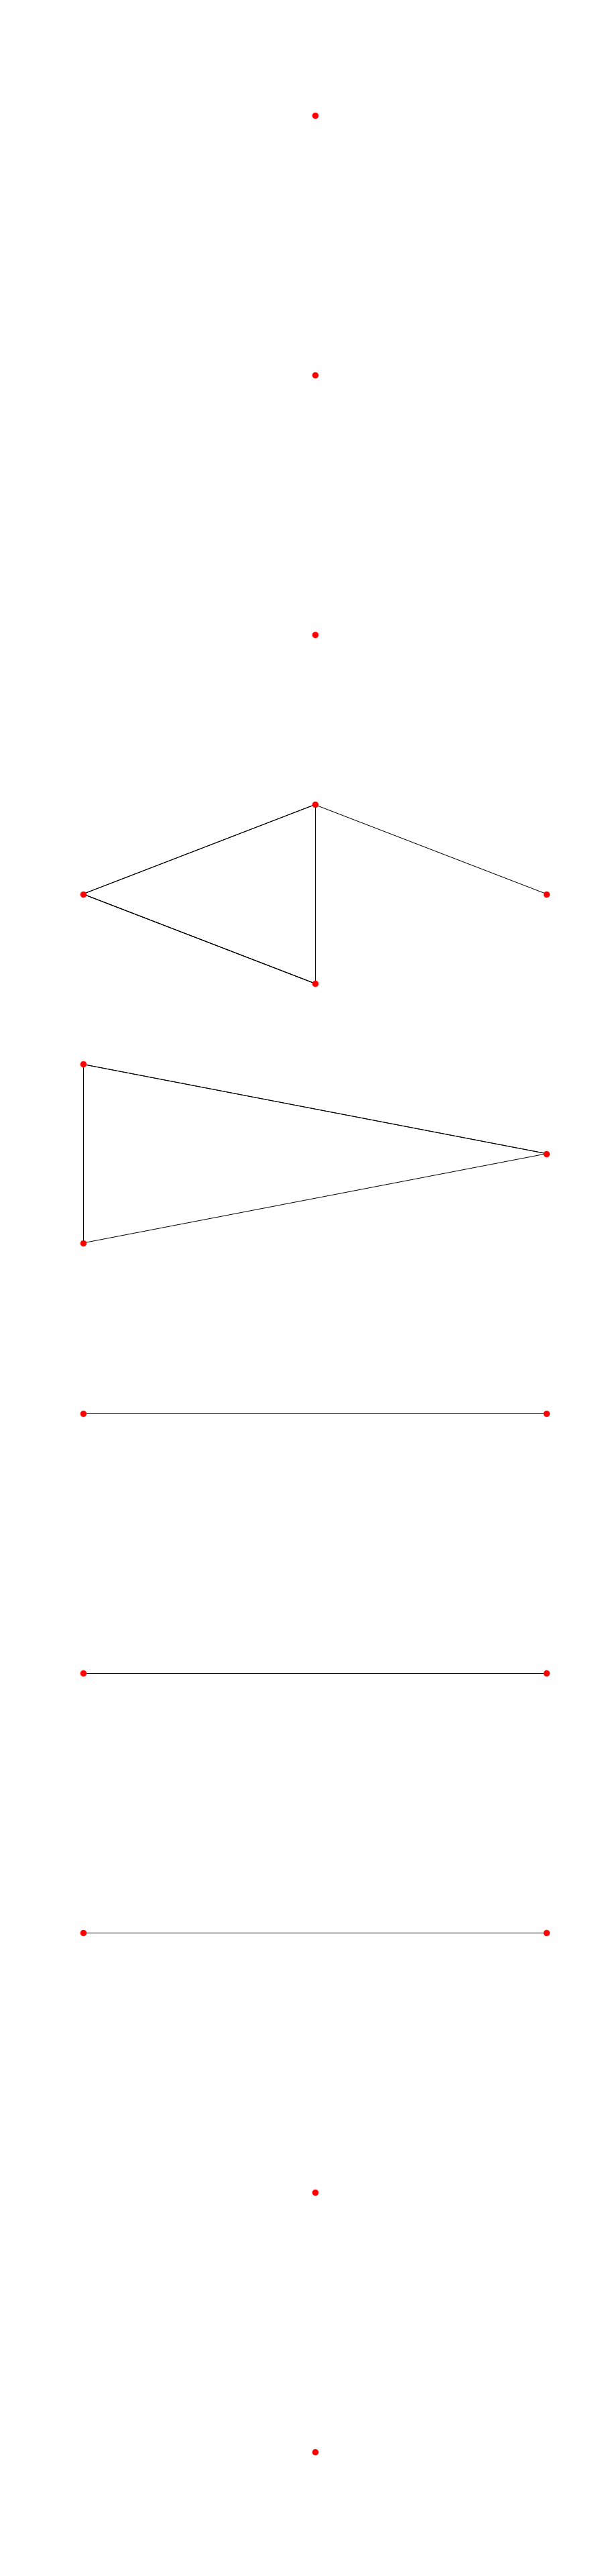

In [40]:
G_n2v.preprocess_transition_probs()

l_walk = 20
walks = G_n2v.simulate_walks(1, l_walk)

walk_lengths = [len(set(walk)) for walk in walks]
print(np.mean(walk_lengths))
#long_walks = [walk for walk in walks if len(walk) == l_walk]
fig, ax_arr = plt.subplots(len(walks),figsize=(15, len(walks)*7))
for i in range(len(walks)):
    walk = walks[i]
    G_walk = G.subgraph(walk).to_undirected()
    #nx.draw_networkx(G_walk, with_labels=False, node_size = 80, ax = ax_arr[i])
    nx.draw_circular(G_walk, with_labels=False, node_size = 80, ax = ax_arr[i])
    #nx.draw_spectral(G_walk, with_labels=False, node_size = 80, ax = ax_arr[i])


    
    #ax_arr[i].set_title(title, fontsize=35)
    ax_arr[i].set_axis_off()
    
plt.show()

/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Walk iteration:
1 / 3
2 / 3
3 / 3
1.8


/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed

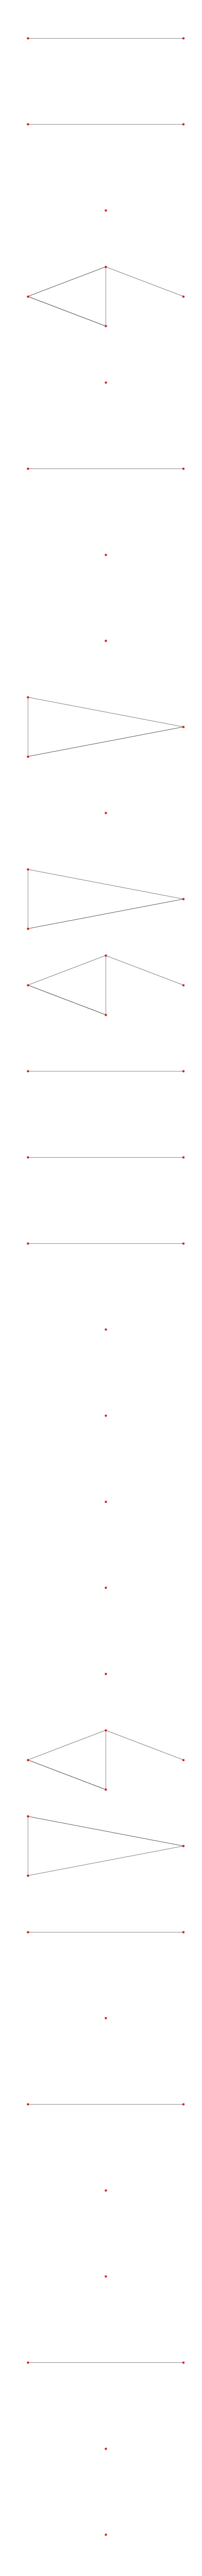

In [43]:
# node2vec parameters
p, q = 100,0.1
G = block_df
edge_df = block_df[['addr_from', 'addr_to']]
edge_df['edge_data'] = block_df[['height', 'weight']].to_dict(orient='records')
edge_list = edge_df.values.tolist()
G = nx.MultiDiGraph(edge_list)
# Keep only nodes with valency at least 3
nodes_ge3 = [n for n in G.nodes() if G.in_degree(n) + G.out_degree(n) >=3]
G = G.subgraph(nodes_ge3)
G_n2v = n2vGraph(G, True, p, q)
G_n2v.preprocess_transition_probs()

l_walk = 50
walks = G_n2v.simulate_walks(3, l_walk)

walk_lengths = [len(set(walk)) for walk in walks]
print(np.mean(walk_lengths))
#long_walks = [walk for walk in walks if len(walk) == l_walk]
fig, ax_arr = plt.subplots(len(walks),figsize=(15, len(walks)*7))
for i in range(len(walks)):
    walk = walks[i]
    G_walk = G.subgraph(walk).to_undirected()
    #nx.draw_networkx(G_walk, with_labels=False, node_size = 80, ax = ax_arr[i])
    nx.draw_circular(G_walk, with_labels=False, node_size = 80, ax = ax_arr[i])
    #nx.draw_spectral(G_walk, with_labels=False, node_size = 80, ax = ax_arr[i])


    
    #ax_arr[i].set_title(title, fontsize=35)
    ax_arr[i].set_axis_off()
    
plt.show()